In [1]:
import glob, os, json, pickle
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from enterprise.signals import gp_signals, signal_base, selections, white_signals, parameter

from enterprise_extensions import models, blocks, model_utils
from enterprise_extensions.frequentist import optimal_statistic as OS

from tqdm.auto import tqdm

# The Optimal Statistic In Practice

In this tutorial, we'll play around with setting up the Optimal Statistic, testing how using different red noise parameters impacts the OS recovery, and looking at different ORFs. 

The datasets that we will be using only have red noise parameters in them, which will speed-up the various calculations. Below we will set-up the PTA object for these simulated datasets. 

In [2]:
datadir = os.path.abspath("OSdata")

# Grab the Pickled Pulsars
nfile = os.path.join(datadir, "viper_OSpickle.pkl")
with open(nfile,'rb') as fin:
    psr_list = pickle.load(fin)

In [3]:
# Make PTA Objects

# Set Tspan for RN
Tspan_PTA = model_utils.get_tspan(psr_list)

# common red noise block
cs = blocks.common_red_noise_block(psd='powerlaw', prior='log-uniform', Tspan=Tspan_PTA,
                                   components=30, gamma_val=4.33, name='gw')

# intrinsic red noise
s = blocks.red_noise_block(prior='log-uniform', Tspan=Tspan_PTA, components=30)

# timing model
s += gp_signals.TimingModel()

# adding EFAC = 1 
ef = white_signals.MeasurementNoise(efac=parameter.Constant(1))

# acting on psr objects
psr_models = []
for psr in psr_list:
        s2 = s + cs + ef
        psr_models.append(s2(psr))

# set up PTA
pta = signal_base.PTA(psr_models)

Now that we have the PTA object made, we can set up the Optimal Statistic. 

When we do this, we will be setting both the spectral shape (gamma value for the PSD) as well as the ORF that we will be incorporating. 

We'll start with HD.

### Optimal Statistic w/ HD ORF
    Looking at the effect of different RN parameters.
    Here we'll look at three different noise values:
        - one where we only include the pulsar's individual noise and no common signal, 
        - one where the common signal amplitude is maximized,
        - and one other random value from an uncorrelated common process Bayesian analysis.

In [4]:
# Make the OS
optstat = OS.OptimalStatistic(psr_list, pta=pta, orf='hd')

In [5]:
# Load json file for first noise test
nfile = os.path.join(datadir, "OS_PulsarOnly_noise.json")
with open(nfile, "r") as f:
    noisedict1 = json.load(f)

In [6]:
xi1, rho1, rho_sig1, opt1, sig1 = optstat.compute_os(params=noisedict1)

`Compute_OS` returns the following information:
- angular separation (xi), 
- the measured correlated power (rho), 
- the uncertainty in the measured correlated power (rho_sig), 
- the measured optimal statistic value (opt),
- and the normalization factor for the OS (sig).

REMEMBER: The SNR for the OS is opt / sig

In [7]:
# Load json file for second noise test 
nfile = os.path.join(datadir, "OS_CommonMax_noise.json")
with open(nfile, "r") as f:
    noisedict2 = json.load(f)
    
xi2, rho2, rho_sig2, opt2, sig2 = optstat.compute_os(params=noisedict2)

In [8]:
# Load json file for third noise test 
nfile = os.path.join(datadir, "OS_CommonMean_noise.json")
with open(nfile, "r") as f:
    noisedict3 = json.load(f)
    
xi3, rho3, rho_sig3, opt3, sig3 = optstat.compute_os(params=noisedict3)

Let's compare these answers. 

In [9]:
print('Pulsar Noise Only - Ahat = ', opt1, ' - SNR = ', opt1/sig1)
print('Pulsar Common Max - Ahat = ', opt2, ' - SNR = ', opt2/sig2)
print('Pulsar Common Mean - Ahat = ', opt3, ' - SNR = ', opt3/sig3)

Pulsar Noise Only - Ahat =  1.6364146547301717e-31  - SNR =  3.6584757651278497
Pulsar Common Max - Ahat =  2.1881511496841375e-31  - SNR =  0.884696006450435
Pulsar Common Mean - Ahat =  2.5801882920711757e-31  - SNR =  2.5363323913727807


#### Plotting the OS Results

Now we'll turn briefly to plotting the OS results using the functions below, which will bin the raw cross-correlation information into a weighted average that is easier to visualize. We'll also overplot the "best-fit" HD curve from the value of the OS. 

In [10]:
def weightedavg(rho, sig):
    weights, avg = 0., 0.
    for r,s in zip(rho,sig):
        weights += 1./(s*s)
        avg += r/(s*s)
        
    return avg/weights, np.sqrt(1./weights)

def bin_crosscorr(zeta, xi, rho, sig):
    
    rho_avg, sig_avg = np.zeros(len(zeta)), np.zeros(len(zeta))
    
    for i,z in enumerate(zeta[:-1]):
        myrhos, mysigs = [], []
        for x,r,s in zip(xi,rho,sig):
            if x >= z and x < (z+10.):
                myrhos.append(r)
                mysigs.append(s)
        rho_avg[i], sig_avg[i] = weightedavg(myrhos, mysigs)
        
    return rho_avg, sig_avg

def get_HD_curve(zeta):
    
    coszeta = np.cos(zeta*np.pi/180.)
    xip = (1.-coszeta) / 2.
    HD = 3.*( 1./3. + xip * ( np.log(xip) -1./6.) )
    
    return HD

In [11]:
z = np.linspace(0,180,19)
rho_avg, sig_avg = bin_crosscorr(z, xi2*180/np.pi, rho2, rho_sig2)

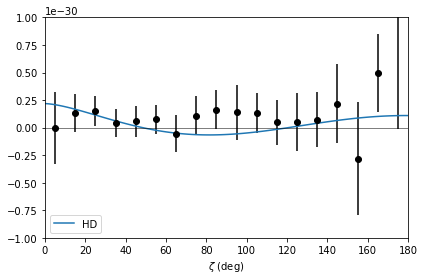

In [12]:
plt.errorbar(z+5, rho_avg, marker='o', yerr=sig_avg, ls='', color='k')

zeta = np.linspace(0.01,180,100)
HD = get_HD_curve(zeta+1)
plt.plot(zeta, HD*opt2, color='C0', label='HD')
plt.axhline(0, color='k', lw=0.5)

plt.xlim((0,180));
plt.ylim((-1e-30, 1e-30));
plt.xlabel(r'$\zeta$ (deg)');

plt.legend(loc=3);
plt.tight_layout();

Now, do the same three tests with a monopole ORF. 

In [13]:
# Make the OS
optstat_mono = OS.OptimalStatistic(psr_list, pta=pta, orf='monopole')

In [14]:
xi1_mono, rho1_mono, rho_sig1_mono, opt1_mono, sig1_mono = optstat_mono.compute_os(params=noisedict1)
xi2_mono, rho2_mono, rho_sig2_mono, opt2_mono, sig2_mono = optstat_mono.compute_os(params=noisedict2)
xi3_mono, rho3_mono, rho_sig3_mono, opt3_mono, sig3_mono = optstat_mono.compute_os(params=noisedict3)

In [15]:
print('Pulsar Noise Only - Ahat = ', opt1_mono, ' - SNR = ', opt1_mono/sig1_mono)
print('Pulsar Common Max - Ahat = ', opt2_mono, ' - SNR = ', opt2_mono/sig2_mono)
print('Pulsar Common Mean - Ahat = ', opt3_mono, ' - SNR = ', opt3_mono/sig3_mono)

Pulsar Noise Only - Ahat =  -3.505520166215632e-33  - SNR =  -0.43432074422814576
Pulsar Common Max - Ahat =  8.951196901628358e-32  - SNR =  1.9814871912183654
Pulsar Common Mean - Ahat =  4.2663457079159217e-32  - SNR =  2.3156949025439366


Clearly, what you set the red noise parameters to makes a difference!

Now, let's look at the `noise_marginalized_OS`, where we marginalize over the red noise choice resulting in a distribution for the OS.

In [16]:
# Load in an entire uncorrelated common process Bayesian MCMC chain
chain_panda = pd.read_csv(os.path.join(datadir,"OS_m2achain.csv.gz"))
model2Achain = chain_panda.to_numpy()[int(chain_panda.shape[0]*0.25):]
pars = list(chain_panda.keys())

In [17]:
# Set-up NMOS
N = 250
opt_m2a, sig_m2a = np.zeros(N), np.zeros(N)
setpars = {}
for ii in tqdm(range(N)):
    idx = np.random.randint(0, model2Achain.shape[0])
    setpars = dict(zip(pars,model2Achain[idx]))
    ## Calculate OS
    xi_tmp, rho_tmp, rho_sig_tmp, opt_m2a[ii], sig_m2a[ii] = optstat.compute_os(params=setpars)
snr_m2a = opt_m2a / sig_m2a

  0%|          | 0/250 [00:00<?, ?it/s]

Text(0.5, 0, 'Opt Stat HD SNR')

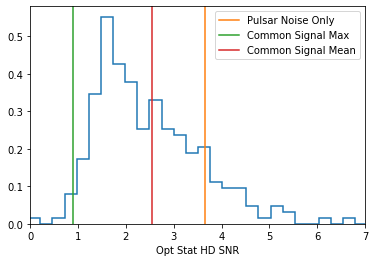

In [18]:
# Plot the resulting distribution and compare to the individual noise runs
plt.hist(snr_m2a, histtype='step', lw=1.5, bins=30, density=True, color='C0')
plt.axvline(opt1/sig1, label='Pulsar Noise Only', color='C1')
plt.axvline(opt2/sig2, label='Common Signal Max', color='C2')
plt.axvline(opt3/sig3, label='Common Signal Mean', color='C3')
plt.legend(loc=1)
plt.xlim(0,7)
plt.xlabel('Opt Stat HD SNR')

Now try running the `Noise_Marginalized_OS` for the monopole and plotting those distributions in the same way.

In [19]:
# Set-up NMOS
N = 250
opt_mono, sig_mono = np.zeros(N), np.zeros(N)
setpars_mono = {}
for ii in tqdm(range(N)):
    idx = np.random.randint(0, model2Achain.shape[0])
    setpars_mono = dict(zip(pars,model2Achain[idx]))
    ## Calculate OS
    xi_tmp, rho_tmp, rho_sig_tmp, opt_mono[ii], sig_mono[ii] = optstat_mono.compute_os(params=setpars_mono)
snr_mono = opt_mono / sig_mono

  0%|          | 0/250 [00:00<?, ?it/s]

Text(0.5, 0, 'Opt Stat HD SNR')

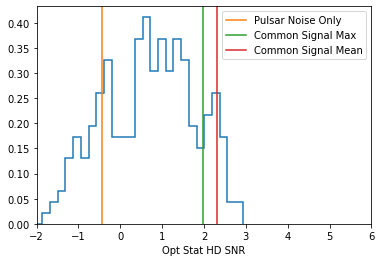

In [20]:
# Plot the resulting distribution and compare to the individual noise runs
plt.hist(snr_mono, histtype='step', lw=1.5, bins=30, density=True, color='C0')
plt.axvline(opt1_mono/sig1_mono, label='Pulsar Noise Only', color='C1')
plt.axvline(opt2_mono/sig2_mono, label='Common Signal Max', color='C2')
plt.axvline(opt3_mono/sig3_mono, label='Common Signal Mean', color='C3')
plt.legend(loc=1)
plt.xlim(-2,6)
plt.xlabel('Opt Stat HD SNR')

Text(0.5, 0, 'Opt Stat HD SNR')

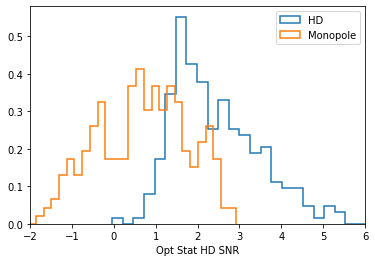

In [21]:
# Compare
plt.hist(snr_m2a, histtype='step', lw=1.5, bins=30, density=True, color='C0', label='HD')
plt.hist(snr_mono, histtype='step', lw=1.5, bins=30, density=True, color='C1', label='Monopole')
plt.legend(loc=1)
plt.xlim(-2,6)
plt.xlabel('Opt Stat HD SNR')

Text(0.5, 0, 'Opt Stat HD SNR')

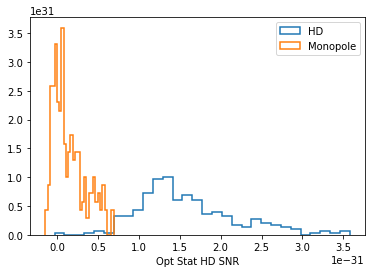

In [22]:
# Plot the resulting distribution and compare to the individual noise runs
plt.hist(opt_m2a, histtype='step', lw=1.5, bins=30, density=True, color='C0', label='HD')
plt.hist(opt_mono, histtype='step', lw=1.5, bins=30, density=True, color='C1', label='Monopole')
plt.legend(loc=1)
# plt.xlim(-2,6)
plt.xlabel('Opt Stat HD SNR')

## Other Things To Do:
    - Look at the value of the Opt Stat in addition to the SNR.
    - Test out another ORF (dipole perhaps?).
    - There are two other simulated datasets, one with a smaller injected GW and one with a louder one.
      Play around with these to see what impact the choice of the noise values has when the signal changes. 